## Final Project - Road Accidents in France in 2019

In [1]:
import os
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import math
import warnings
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
from collections import Counter

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, balanced_accuracy_score


### Import des fichiers de données

In [2]:
carac = pd.read_csv("../Mini-Project/data/caracteristiques-2019.csv", sep=";") # nous donne des caractéristiques sur les accidents
lieux = pd.read_csv("../Mini-Project/data/lieux-2019.csv", sep=";") # recense des données sur les lieux des accidents
veh = pd.read_csv("../Mini-Project/data/vehicules-2019.csv", sep=";") # donne des informations sur les véhicules impliqués
usagers = pd.read_csv("../Mini-Project/data/usagers-2019.csv", sep=";") # donne des informations sur les victimes

In [3]:
print(f'Forme de carac = {carac.shape}')
print(f'Forme de lieux = {lieux.shape}')
print(f'Forme de veh = {veh.shape}')
print(f'Forme de usagers = {usagers.shape}')

Forme de carac = (58840, 15)
Forme de lieux = (58840, 18)
Forme de veh = (100710, 11)
Forme de usagers = (132977, 15)


In [4]:
print(set(veh.columns).intersection(set(lieux.columns).intersection(set(carac.columns).intersection(set(usagers.columns)))))
print(set(veh.columns).intersection(set(usagers.columns)))

{'Num_Acc'}
{'Num_Acc', 'id_vehicule', 'num_veh'}


**Observations**

Les 4 fichiers ont en commun la colonne 'NumAcc' (numéro d'accident).

Les fichiers 'vehicules' et 'usagers' ont en commun 2 colonnes supplémentaires : 'num_veh' (identifiant de véhicule) et 'id_vehicule' (identifiant unique du véhicule). 

In [5]:
print("fichier 'carac':")
print(f"Number of NumAcc unique values = {carac.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(carac.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(carac)}')
print()
print("fichier 'lieux':")
print(f"Number of NumAcc unique values = {lieux.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(lieux.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(lieux)}')
print()
print("fichier 'veh':")
print(f"Number of NumAcc unique values = {veh.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(veh.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(veh)}')
print()
print("fichier 'usagers':")
print(f"Number of NumAcc unique values = {usagers.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(usagers.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(usagers)}')
print()

fichier 'carac':
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 1
Number of rows = 58840

fichier 'lieux':
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 1
Number of rows = 58840

fichier 'veh':
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 12
Number of rows = 100710

fichier 'usagers':
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 33
Number of rows = 132977



**Observations**

A ce stade on peut supposer que : 
- chaque fichier recense les mêmes 58140 accidents, identifiés par leur identifiant unique. 
- ces 58140 accidents sont survenus chacun dans un lieu distinct (d'où 58140 lieux distincts), ont impliqué un nombre de véhicules plus ou moins grand (de 1 à 12) et occasionné un nombre de usagersimes plus ou moins grand (de 1 à 33).
Pour confirmer ces chiffres, nous devrons au préalable supprimer les éventuelles lignes en double dans chaque fichier.

### Fusion des fichiers

Notre étude porte sur la gravité des accidents pour les victimes, nous souhaitons donc disposer d'un fichier unique qui comptera 1 ligne par victime distincte.
Nous fusionnons donc le fichier 'usagers' avec les 3 autres en excluant les lignes supplémentaires éventuelles de ces autres fichiers.

In [6]:
victime = (usagers.merge(veh,
                      on=['Num_Acc','id_vehicule','num_veh'], 
                      how='left')
           .merge(carac,
                  on = 'Num_Acc', 
                  how='left')
           .merge(lieux, 
                  on=['Num_Acc'], 
                  how='left'))

### Premières observations sur le fichier

In [7]:
victime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132977 entries, 0 to 132976
Data columns (total 54 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      132977 non-null  int64  
 1   id_vehicule  132977 non-null  object 
 2   num_veh      132977 non-null  object 
 3   place        132977 non-null  int64  
 4   catu         132977 non-null  int64  
 5   grav         132977 non-null  int64  
 6   sexe         132977 non-null  int64  
 7   an_nais      132977 non-null  int64  
 8   trajet       132977 non-null  int64  
 9   secu1        132977 non-null  int64  
 10  secu2        132977 non-null  int64  
 11  secu3        132977 non-null  int64  
 12  locp         132977 non-null  int64  
 13  actp         132977 non-null  object 
 14  etatp        132977 non-null  int64  
 15  senc         132977 non-null  int64  
 16  catv         132977 non-null  int64  
 17  obs          132977 non-null  int64  
 18  obsm         132977 non-

Réorganisons l'ordre des colonnes, avec notre donnée cible ('grav') à la fin, et donnons-leur des noms plus explicites.

In [8]:
victime.rename(columns={"agg":"agglo", "int":"intersection",
                        "atm":"meteo","col":"collision",
                        'catr':'type_route','circ':'type_circu',
                        'nbv':'nb_voies', 'prof':'declivite',
                        'plan':'rectitude',"surf":"surface",
                        'infra':'infrastructure','situ':'situ_acc',
                        'vma':'vitesse_autorisee','senc':'sens_circu',
                        'catv':'type_veh','obs':"obst_fixe",'obsm':'obst_mobile',
                        'manv':'manoeuvre_veh','place':'place_veh',
                        'catu':'type_usager','locp':'loc_pieton',
                        'actp':'manoeuvre_pieton','etatp':'pieton_seul'},
               inplace=True)

In [9]:
victime = victime[['Num_Acc', 'an', 'mois', 'jour', 'hrmn', 'lum', 'dep', 'com', 'agglo', 'intersection', 'meteo', 'collision', 'adr', 'lat', 'long','type_route', 'voie', 'v1', 'v2','type_circu', 'nb_voies', 'vosp', 'declivite', 'pr', 'pr1', 'rectitude', 'lartpc', 'larrout','surface', 'infrastructure', 'situ_acc', 'vitesse_autorisee',
         'id_vehicule', 'sens_circu', 'type_veh', 'obst_fixe', 'obst_mobile', 'choc', 'manoeuvre_veh', 'motor', 'occutc', 'num_veh', 'place_veh', 'type_usager', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'loc_pieton', 'manoeuvre_pieton', 'pieton_seul', 'grav']]

In [10]:
victime.head()

,Num_Acc,an,mois,jour,hrmn,lum,dep,com,agglo,intersection,...,sexe,an_nais,trajet,secu1,secu2,secu3,loc_pieton,manoeuvre_pieton,pieton_seul,grav
0,201900000001,2019,11,30,01:30,4,93,93053,1,1,...,2,2002,0,1,0,-1,-1,-1,-1,4
1,201900000001,2019,11,30,01:30,4,93,93053,1,1,...,2,1993,5,1,0,-1,-1,-1,-1,4
2,201900000001,2019,11,30,01:30,4,93,93053,1,1,...,1,1959,0,1,0,-1,-1,-1,-1,1
3,201900000002,2019,11,30,02:50,3,93,93066,1,1,...,2,1994,0,1,0,-1,-1,-1,-1,4
4,201900000003,2019,11,28,15:15,1,92,92036,1,1,...,1,1996,0,1,0,-1,-1,0,-1,1


**Premières observations**
- Etat de la route, type de véhicule, gravité de l'accident... : la plupart des données sont catégorielles, et codifiées sous la forme d'un chiffre entre -1 et 10. Nous devrons créer des variables factices en vue du traitement ultérieur de machine learning. 
- Plusieurs colonnes montrent des valeurs manquantes, auxquelles nous devrons remédier.
- (Nous commencerons par la conversion en format numérique des colonnes, celle-ci étant susceptible de générer des valeurs manquantes.)

### Preprocessing 

**Correction des formats de données**

In [11]:
print(f'Initialement, {len(list(victime.dtypes[victime.dtypes == object]))} colonnes sont au format "objet" : {list(victime.dtypes[victime.dtypes == object].index)}')

Initialement, 13 colonnes sont au format "objet" : ['hrmn', 'dep', 'com', 'adr', 'lat', 'long', 'voie', 'v2', 'pr', 'pr1', 'id_vehicule', 'num_veh', 'manoeuvre_pieton']


**Observations**
Ce sont toutes des colonnes de type qualitatif, le format est donc adéquat à ce stade. 
NB : avant le traitement de machine learning, nous devrons les convertir en variables factices.

In [12]:
#La série 'id_véhicule' doit être nettoyée pour pouvoir être convertie en format numérique.
#victime.loc[0,'id_vehicule']

#from unicodedata import normalize
#import re
#def clean_up(text):
    #text = normalize('NFKD', text)
    #text = re.sub('\W*','',text)
    #return int(text)

#ictime['id_vehicule'] = victime['id_vehicule'].apply(clean_up)

#check
#victime['id_vehicule'].dtypes

In [13]:
#print(f"Les colonnes suivantes peuvent être directement converties au format numérique : {aconvertir}")
#aconvertir = ['manoeuvre_pieton','dep']

#def convert_to_numeric(col):
    #victime[col] = pd.to_numeric(victime[col], errors='coerce')

#for c in aconvertir:
    #convert_to_numeric(c) 

#print(victime.dtypes)

In [14]:
numlist = list(victime.dtypes[victime.dtypes != object].index)
print(f"Les {len(numlist)} autres variables sont sous format chiffré (nombre entier ou décimal) : {numlist}")
print(f"Seules quelques-unes sont réllement de nature numérique, nous convertissons donc les autres au format 'objet' afin de refléter leur nature catégorielle et faciliter l'encodage qui devra avoir lieu avant le  machine learning.")

Les 41 autres variables sont sous format chiffré (nombre entier ou décimal) : ['Num_Acc', 'an', 'mois', 'jour', 'lum', 'agglo', 'intersection', 'meteo', 'collision', 'type_route', 'v1', 'type_circu', 'nb_voies', 'vosp', 'declivite', 'rectitude', 'lartpc', 'larrout', 'surface', 'infrastructure', 'situ_acc', 'vitesse_autorisee', 'sens_circu', 'type_veh', 'obst_fixe', 'obst_mobile', 'choc', 'manoeuvre_veh', 'motor', 'occutc', 'place_veh', 'type_usager', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'loc_pieton', 'pieton_seul', 'grav']
Seules quelques-unes sont réllement de nature numérique, nous convertissons donc les autres au format 'objet' afin de refléter leur nature catégorielle et faciliter l'encodage qui devra avoir lieu avant le  machine learning.


In [15]:
def convert_to_string(col):
    victime[col] = victime[col].astype(str)

numlist.remove('jour')
numlist.remove('mois')
numlist.remove('an')
numlist.remove('vitesse_autorisee')
numlist.remove('nb_voies')
numlist.remove('occutc')
numlist.remove('lartpc')
numlist.remove('larrout')
numlist.remove('an_nais')

for e in numlist:
    convert_to_string(e)
victime.dtypes

Num_Acc               object
an                     int64
mois                   int64
jour                   int64
hrmn                  object
lum                   object
dep                   object
com                   object
agglo                 object
intersection          object
meteo                 object
collision             object
adr                   object
lat                   object
long                  object
type_route            object
voie                  object
v1                    object
v2                    object
type_circu            object
nb_voies               int64
vosp                  object
declivite             object
pr                    object
pr1                   object
rectitude             object
lartpc               float64
larrout              float64
surface               object
infrastructure        object
situ_acc              object
vitesse_autorisee      int64
id_vehicule           object
sens_circu            object
type_veh      

In [16]:
print(f"Nous avons donc désormais, dans notre jeu de données, {len(list(victime.dtypes[victime.dtypes == object].index))} colonnes catégorielles de type 'texte' et {len(list(victime.dtypes[victime.dtypes != object].index))} variables numériques de type 'chiffre' (entier ou décimal).")

Nous avons donc désormais, dans notre jeu de données, 45 colonnes catégorielles de type 'texte' et 9 variables numériques de type 'chiffre' (entier ou décimal).


In [17]:
victime.nb_voies = victime.nb_voies.astype('int64')
victime.vitesse_autorisee = victime.vitesse_autorisee.astype('int64')

**Correction des variables**

La codification des variables catégorielles n'est pas complètement harmonisée entre colonnes. 
- De manière générale, les valeurs manquantes sont repérées par l'absence de valeur, mais également par les valeurs '-1', (1), '0' ou '8' suivant la variable considérée.
- De même, "Non applicable / Sans objet" est repéré, suivant les variables, par la valeur '0, '1', '7' ou l'absence de valeur.
- Dans certains cas, la valeur "0" signifie "aucun".
Nous procédons à une harmonisation :
- Manquant = -1
- Non applicable = IRLVT

In [18]:
# Variable 'int' (intersection) : changement de "hors intersection" (1) à "IRLVT".
print(sorted(victime.intersection.value_counts().index))
victime.loc[victime.intersection=='1','intersection']='IRLVT'

['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [19]:
# Variable 'collision' : changement de "sans collision" (7) à "IRLVT".
print(sorted(victime.collision.value_counts().index))
victime.loc[victime.collision=='7','collision']='IRLVT'

['-1', '1', '2', '3', '4', '5', '6', '7']


In [20]:
# Variable "sens de la circulation" : changement de "inconnu" (0) à "valeur manquante", changement de "repère absent" (3) à "IRLVT".
print(sorted(victime.sens_circu.value_counts().index))
victime.loc[victime.sens_circu=='0','sens_circu']='-1'
victime.loc[victime.sens_circu=='3','sens_circu']='IRLVT'

['-1', '0', '1', '2', '3']


In [21]:
# Changement de "type de voie réservée" de "sans objet" à "IRLVT".
print(sorted(victime.vosp.value_counts().index))
victime.loc[victime.vosp=='0','vosp']='IRLVT'

['-1', '0', '1', '2', '3']


In [22]:
# Changement de "type d'infrastructure" de "aucun" à "IRLVT".
print(sorted(victime.infrastructure.value_counts().index))
victime.loc[victime.infrastructure=='0','infrastructure']='IRLVT'

['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [23]:
# Changement de "type de véhicule" de "inconnu" à "valeur manquante".
print(sorted(victime.type_veh.value_counts().index))
victime.loc[victime.type_veh=='0','type_veh']='-1'

['0', '1', '10', '13', '14', '15', '16', '17', '2', '20', '21', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '50', '60', '7', '80', '99']


In [24]:
# Changement de "type d'obstacle" de "sans objet" à "IRLVT".
print(sorted(victime.obst_fixe.value_counts().index))
victime.loc[victime.obst_fixe=='0','obst_fixe']='IRLVT'

['-1', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


In [25]:
# Changement de "type d'obstacle mobile" de "aucun" à "IRLVT".
print(sorted(victime.obst_mobile.value_counts().index))
victime.loc[victime.obst_mobile=='0','obst_mobile']='IRLVT'

['-1', '0', '1', '2', '4', '5', '6', '9']


In [26]:
# Changement de "type de choc" de "aucun" à "IRLVT".
print(sorted(victime.choc.value_counts().index))
victime.loc[victime.choc=='0','choc']='IRLVT'

['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [27]:
# Changement de "manoeuvre du véhicule" de "inconnue" à "valeur manquante".
print(sorted(victime.manoeuvre_veh.value_counts().index))
victime.loc[victime.manoeuvre_veh=='0','manoeuvre_veh']='-1'

['-1', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7', '8', '9']


In [28]:
# Changement de "motorisation" de "inconnue" à "valeur manquante".
print(sorted(victime.motor.value_counts().index))
victime.loc[victime.motor=='0','motor']='-1'

['-1', '0', '1', '2', '3', '4', '5', '6']


In [29]:
# Changement du type de trajet de "non renseigné" à "valeur manquante".
print(sorted(victime.trajet.value_counts().index))
victime.loc[victime.trajet=='0', 'trajet'] = '-1'

['-1', '0', '1', '2', '3', '4', '5', '9']


In [30]:
# Changement de "type d'équipement" de "non déterminable" à "valeur manquante".
print(sorted(victime.secu1.value_counts().index))
victime.loc[victime.secu1=='8','secu1']='-1'

['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [31]:
# Variables "localisation du piéton" et "manoeuvre du piéton"
print(sorted(victime.manoeuvre_pieton.value_counts().index))
print(sorted(victime.loc_pieton.value_counts().index))
victime.loc[(victime.type_usager=='3')&(victime.manoeuvre_pieton =='0'),'manoeuvre_pieton']="-1"
victime.loc[(victime.type_usager=='3')&(victime.loc_pieton =='0'),'loc_pieton']="-1"
victime.loc[victime.type_usager!='3','manoeuvre_pieton']="IRLVT"
victime.loc[victime.type_usager!='3','loc_pieton']="IRLVT"
victime.loc[victime.type_usager!='3','pieton_seul']="IRLVT"

[' -1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B']
['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [32]:
victime.loc[victime.num_veh=='CB01','num_veh']='-1'
victime.loc[victime.num_veh=='LB01','num_veh']='-1'
victime.loc[victime.num_veh=='MA01','num_veh']='-1'
victime.loc[victime.num_veh=='VF01','num_veh']='-1'
victime.loc[victime.num_veh=="\\01",'num_veh']='-1'

In [33]:
victime.replace(-1, np.NaN, inplace=True)
victime = victime.replace(r'^-1$', np.NaN, regex=True)
victime = victime.replace(r'^ -1$', np.NaN, regex=True)
victime = victime.replace(r'^\(1\)$', np.NaN, regex=True)

In [34]:
victime.dep.replace({'1':'01',
                     '2':'02',
                     '3':'03',
                     '4':'04',
                     '5':'05',
                     '6':'06',
                     '7':'07',
                     '8':'08',
                     '9':'09'},
                     inplace=True)

In [35]:
victime.shape

(132977, 54)

**Valeurs manquantes**

Imprimons le ratio de valeurs manquantes par colonne.

In [36]:
percent_missing = victime.isna().sum() * 100 / len(victime)
missing_values = pd.DataFrame({'missing_%': percent_missing}, index = victime.columns).sort_values(by='missing_%', ascending=False)
missing_values

,missing_%
lartpc,99.648811
larrout,99.375080
secu3,98.680975
occutc,98.587726
v2,92.673921
secu2,30.203719
trajet,26.259428
secu1,14.570941
pr1,12.378832
pr,11.867466


In [37]:
more_than_10 = list(missing_values[(missing_values['missing_%']>=10)].index)
print(f"Supprimons les {len(more_than_10)} colonnes qui contiennent plus de 10% de valeurs manquantes : {more_than_10}")
victime.drop(columns=more_than_10, axis = 1, inplace = True)

Supprimons les 11 colonnes qui contiennent plus de 10% de valeurs manquantes : ['lartpc', 'larrout', 'secu3', 'occutc', 'v2', 'secu2', 'trajet', 'secu1', 'pr1', 'pr', 'motor']


In [38]:
less_than_1 = list(missing_values[(missing_values['missing_%']>0)&(missing_values['missing_%']<1)].index)
print(f"Ensuite, suppprimons les lignes dont les valeurs manquantes représentent moins d'1% de leurs colonnes respectives : {less_than_1}.")
victime.dropna(subset = less_than_1, inplace = True)

Ensuite, suppprimons les lignes dont les valeurs manquantes représentent moins d'1% de leurs colonnes respectives : ['adr', 'type_veh', 'loc_pieton', 'situ_acc', 'manoeuvre_pieton', 'pieton_seul', 'infrastructure', 'obst_mobile', 'choc', 'obst_fixe', 'surface', 'declivite', 'rectitude', 'num_veh', 'collision', 'meteo'].


In [39]:
between_1_and_10 = list(missing_values[(missing_values['missing_%']>=1)&(missing_values['missing_%']<10)].index)
print(f"Enfin, {len(between_1_and_10)} colonnes ont un ratio de valeurs manquantes comprises entre 1 et 10% : {between_1_and_10}.")
print("Nous décidons de remplacer les valeurs manquantes des séries catégorielles par la valeur majoritaire, et celles des séries numériques par la valeur médiane.")

Enfin, 7 colonnes ont un ratio de valeurs manquantes comprises entre 1 et 10% : ['sens_circu', 'manoeuvre_veh', 'type_circu', 'voie', 'vitesse_autorisee', 'vosp', 'nb_voies'].
Nous décidons de remplacer les valeurs manquantes des séries catégorielles par la valeur majoritaire, et celles des séries numériques par la valeur médiane.


In [40]:
victime.sens_circu.fillna(victime.sens_circu.mode()[0], inplace=True)
victime.manoeuvre_veh.fillna(victime.manoeuvre_veh.mode()[0], inplace=True)
victime.type_circu.fillna(victime.type_circu.mode()[0], inplace=True)
victime.voie.fillna(victime.voie.mode()[0], inplace=True)
victime.vosp.fillna(victime.vosp.mode()[0], inplace=True)
victime.vitesse_autorisee.fillna(victime.vitesse_autorisee.median(), inplace=True)
victime.nb_voies.fillna(victime.nb_voies.median(), inplace=True)

Vérifions que plus aucune valeur ne manque à notre jeu de données :

In [41]:
if victime.isna().sum().any() == False:
    print('Plus de valeur manquante dans le jeu de données.')
else:
    print(victime.isna().sum())

Plus de valeur manquante dans le jeu de données.


In [42]:
victime.shape

(130901, 43)

**Valeurs aberrantes**

Repérons et traitons les valeurs aberrantes.

In [43]:
victimeminmax = pd.DataFrame({'victime_valeur_min':victime.min(), 'victime_valeur_max':victime.max()})
victimeminmax

,victime_valeur_min,victime_valeur_max
Num_Acc,201900000001,201900058840
an,2019,2019
mois,1,12
jour,1,31
hrmn,00:00,23:59
lum,1,5
dep,01,988
com,01004,98833
agglo,1,2
intersection,2,IRLVT


**Observations**

En premier lieu, la colonne 'vitesse_autorisee', avec des bornes de 0 km/h et 800 km/h, comprend de toute évidence des valeurs aberrantes.
Nous décidons de la winsoriser.

<AxesSubplot:>

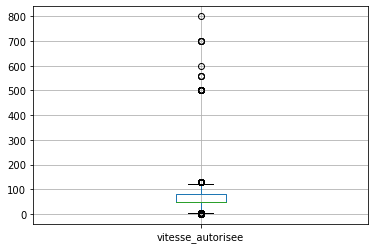

In [44]:
victime.boxplot(column=['vitesse_autorisee'])

In [45]:
upper = 130
lower = 10
victime.vitesse_autorisee = victime['vitesse_autorisee'].clip(lower, upper)

<AxesSubplot:>

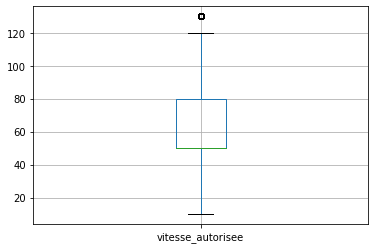

In [46]:
victime.boxplot(column=['vitesse_autorisee'])

In [47]:
victime.vitesse_autorisee.dtypes

dtype('float64')

De même, l'année de naissance de la victime, qui commence à l'année 1900, est sans doute erronée. Nous décidons également de la winsoriser.

<AxesSubplot:>

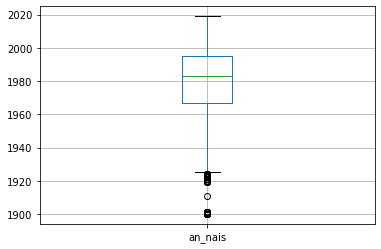

In [48]:
victime.boxplot(column=['an_nais'])

In [49]:
upper = 2019
lower = 1909
victime.an_nais = victime['an_nais'].clip(lower, upper)

<AxesSubplot:>

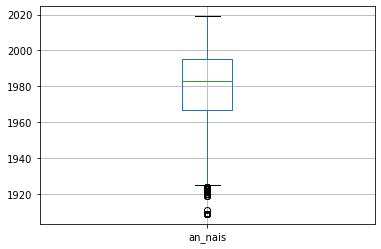

In [50]:
victime.boxplot(column=['an_nais'])

Sauvegardons le jeu de données nettoyé avant de l'adapter au machine learning.

In [51]:
victime.reset_index(inplace=True, drop=True)
victime.index

RangeIndex(start=0, stop=130901, step=1)

In [52]:
victime.to_csv('../Final-Project/data/victime_clean.csv', index=False)

**Feature Selection**

In [195]:
victml = victime.copy()

In [196]:
victml.dtypes

Num_Acc               object
an                     int64
mois                   int64
jour                   int64
hrmn                  object
lum                   object
dep                   object
com                   object
agglo                 object
intersection          object
meteo                 object
collision             object
adr                   object
lat                   object
long                  object
type_route            object
voie                  object
v1                    object
type_circu            object
nb_voies             float64
vosp                  object
declivite             object
rectitude             object
surface               object
infrastructure        object
situ_acc              object
vitesse_autorisee    float64
id_vehicule           object
sens_circu            object
type_veh              object
obst_fixe             object
obst_mobile           object
choc                  object
manoeuvre_veh         object
num_veh       

In [197]:
victml.vitesse_autorisee = victml.vitesse_autorisee.astype('int64')
victml.nb_voies = victml.nb_voies.astype('int64')

**Etude de la nature des variables - Sélection de colonnes**

Les variables suivantes ne nous paraissent pas de nature à influencer positivement la classification de la variable cible (non pertinence ou risque de surapprentissage/overfitting). Nous choisissons de les écarter : 
- l'année (toujours 2019)
- les identifiants uniques de l'accident et du véhicule,
- l'année (toujours 2019) et le jour de l'accident (on garde le mois), 
- heure/min de l'accident (on garde l'éclairage), 
- adresse postale et le code postal de la commune (on garde le numéro de département et la distinction agglo/hors agglo),
- latitude/longitude,
- le numéro de la route et son indice numérique,
- l'existence d'une voie réservée, que l'accident s'y soit produit ou pas.

In [198]:
victml.drop(['Num_Acc','id_vehicule','an','jour','hrmn','adr','com','lat','long','v1','voie','vosp'], axis=1, inplace=True, errors = 'ignore')

In [199]:
victml.shape

(130901, 31)

In [200]:
victml.columns

Index(['mois', 'lum', 'dep', 'agglo', 'intersection', 'meteo', 'collision',
       'type_route', 'type_circu', 'nb_voies', 'declivite', 'rectitude',
       'surface', 'infrastructure', 'situ_acc', 'vitesse_autorisee',
       'sens_circu', 'type_veh', 'obst_fixe', 'obst_mobile', 'choc',
       'manoeuvre_veh', 'num_veh', 'place_veh', 'type_usager', 'sexe',
       'an_nais', 'loc_pieton', 'manoeuvre_pieton', 'pieton_seul', 'grav'],
      dtype='object')

**Binning des valeurs de chaque variable**

Etudions la proportion des valeurs au sein de chaque variable, et regroupons les valeurs moins fréquentes.
On supprime les variables si l'une des valeurs représente au moins les 3/4 de l'effectif. 

In [201]:
def countplot(col):
    sns.countplot(data = victml[victml[col]!='IRLVT'], x = col, order = list(victml.loc[victml[col]!='IRLVT',col].value_counts().index))

In [202]:
def binning(c):
    if victml[c].nunique()>1:
        if (victml.loc[victml[c]!='IRLVT',c].value_counts()<1200).sum()!=0:
            print(f'COLUMN TO BE BINNED.')
            print(victml.loc[victml[c]!='IRLVT',c].value_counts())
            if (c!='dep') and (c!='type_veh') and (c!='num_veh') and (c!='an_nais'):
                countplot(c)
        else:
            print('BINNING FINE.')
            if c!='dep':
                countplot(c)
        
    else:
        print('COLUMN TO BE DROPPED.')
        countplot(c)

BINNING FINE.


<AxesSubplot:xlabel='mois', ylabel='count'>

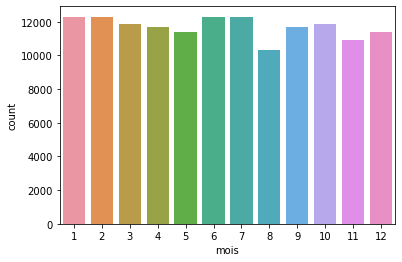

In [203]:
binning('mois')
sns.countplot(data = victml[victml['mois']!='IRLVT'], x = 'mois')

BINNING FINE.


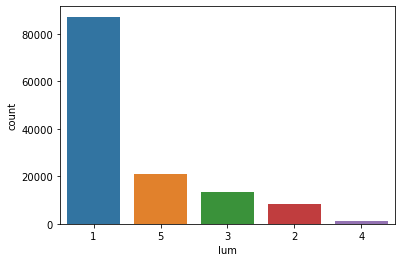

In [204]:
binning('lum')

COLUMN TO BE BINNED.
75     11811
93      6995
13      6948
94      5961
69      5691
       ...  
978       86
39        54
977       30
986       21
975        7
Name: dep, Length: 107, dtype: int64


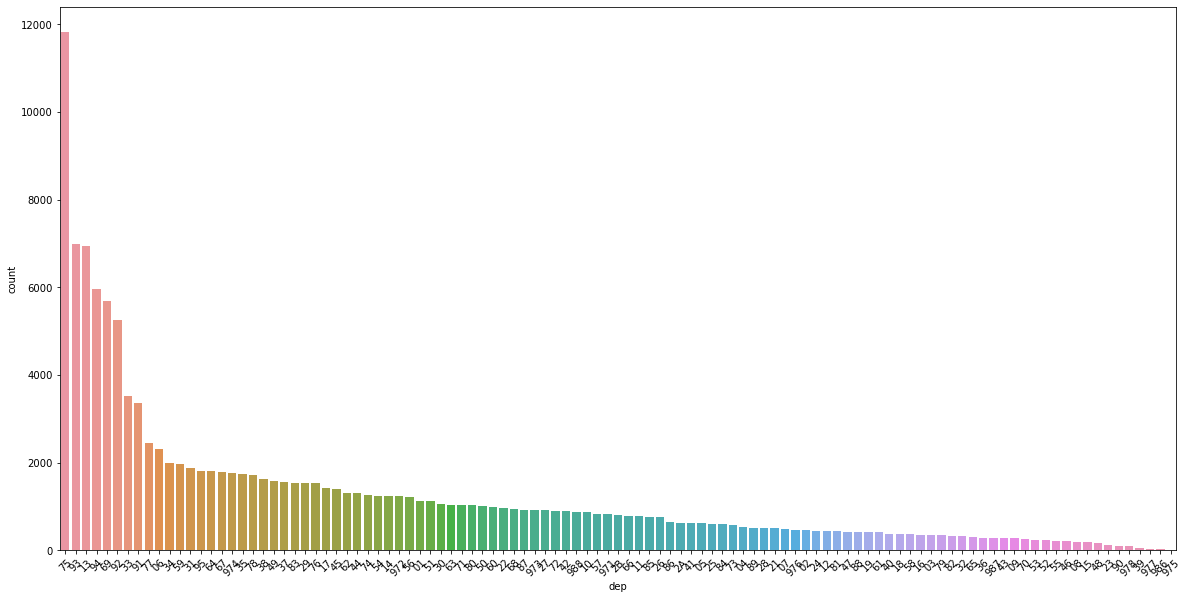

In [205]:
binning('dep')
plt.figure(figsize=(20, 10))
plt.xticks(rotation='45')
countplot('dep')

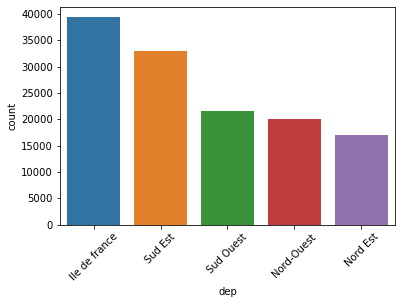

In [206]:
victml.dep.replace(['75','77','78','91','92','93','94','95'], value ="Ile de france", inplace=True)
victml.dep.replace(['44','49','53','72','85','18','28','36','37','41','45','14','50','61','27','76','22','29','35','56'], value= "Nord-Ouest", inplace=True)
victml.dep.replace(['08','10','51','52','59','62','80','02','60','54','55','57','88','21','58','71','89','67','68','25','39','70','90'], value = "Nord Est", inplace=True)
victml.dep.replace(['11','30','34','48','66','04','06','13','05','83','84','03','15','43','63','01','07','26','38','42','69','73','74','2A','2B'], value = "Sud Est", inplace=True)
victml.dep.replace(['09', '12','32','31','65','46','81','82','16','17','79','86','19', '23','87', '24','33','40','47','64','971','972','973','974','975','976','977','978','986','987','988'], value = "Sud Ouest", inplace=True)
plt.xticks(rotation='45')
countplot('dep')

BINNING FINE.


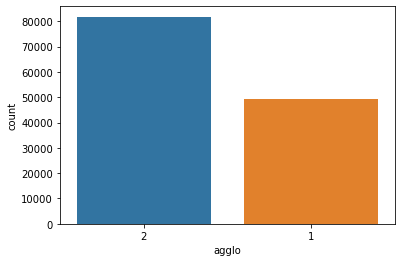

In [207]:
binning('agglo')

COLUMN TO BE BINNED.
2    16354
3    13614
9     5769
6     4457
4     2816
7     1474
5      677
8      134
Name: intersection, dtype: int64


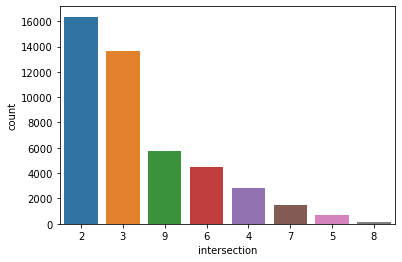

In [208]:
binning('intersection')

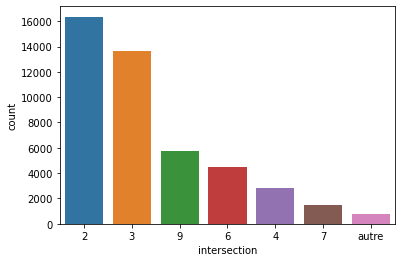

In [209]:
victml.intersection.replace(['5','8'],'autre', inplace=True)
countplot('intersection')

COLUMN TO BE BINNED.
1    103710
2     14565
8      4863
3      3186
7      2267
5       707
9       642
4       600
6       361
Name: meteo, dtype: int64


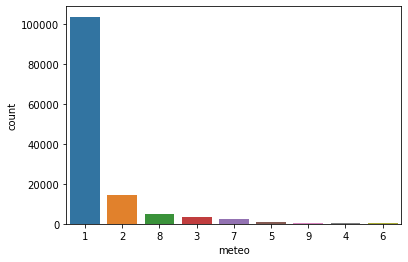

In [210]:
binning('meteo')

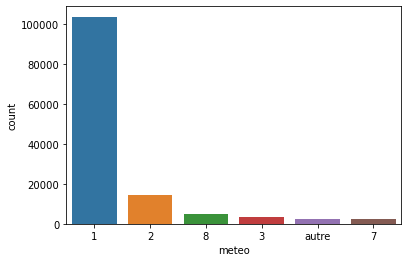

In [211]:
victml.meteo.replace(['6','9','5','4'],'autre', inplace=True)
countplot('meteo')

BINNING FINE.


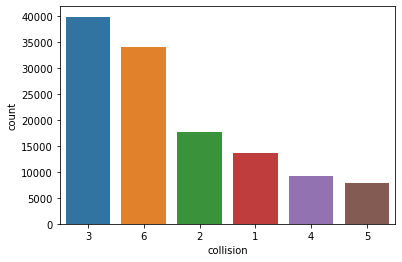

In [212]:
binning('collision')

COLUMN TO BE BINNED.
4    54514
3    46190
1    15659
2     9428
7     2899
9     1183
6      881
5      147
Name: type_route, dtype: int64


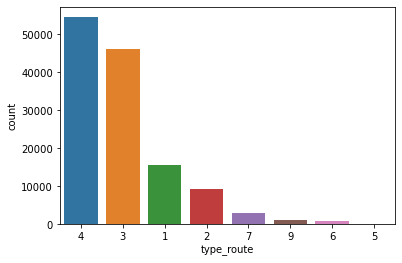

In [213]:
binning('type_route')

COLUMN TO BE BINNED.
2    86080
1    22825
3    21172
4      824
Name: type_circu, dtype: int64


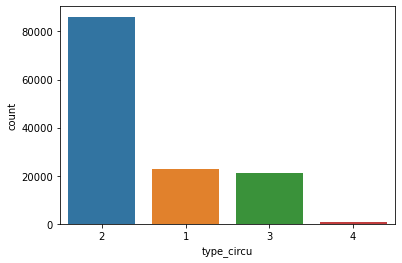

In [214]:
binning('type_circu')

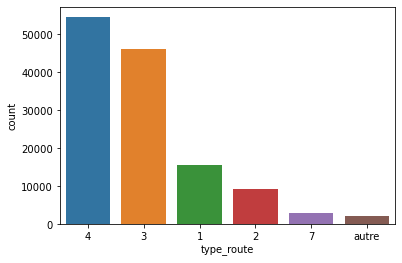

In [215]:
victml.type_route.replace(['5','6','9'],'autre', inplace=True)
countplot('type_route')

BINNING FINE.


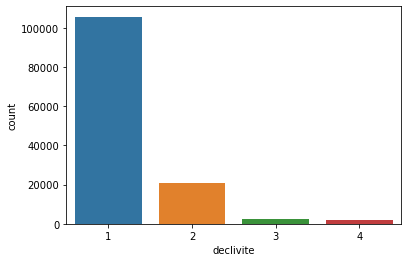

In [216]:
binning('declivite')

BINNING FINE.


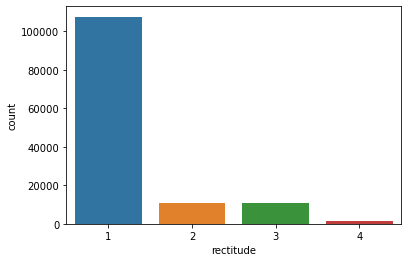

In [217]:
binning('rectitude')

COLUMN TO BE BINNED.
1    104772
2     24326
9       604
7       426
5       243
3       235
8       196
6        58
4        41
Name: surface, dtype: int64


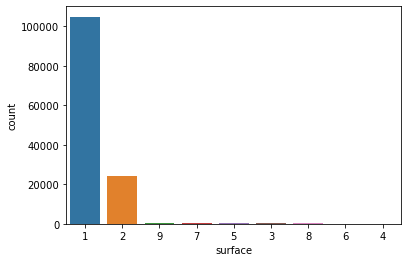

In [218]:
binning('surface')

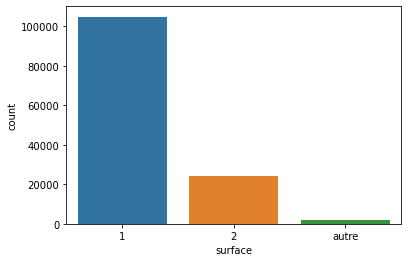

In [219]:
victml.surface.replace(['3','4','5','6','7','8','9'],'autre', inplace=True)
countplot('surface')

COLUMN TO BE BINNED.
5    7797
9    4807
2    2641
3    2054
1    1794
8    1128
6    1126
4     540
7      99
Name: infrastructure, dtype: int64


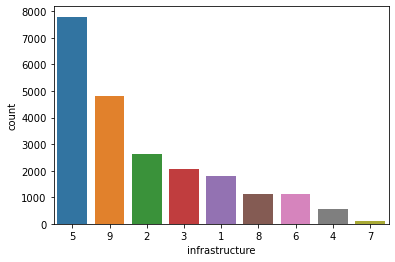

In [220]:
binning('infrastructure')

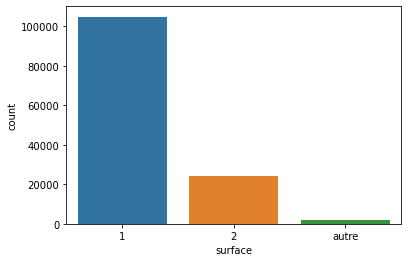

In [221]:
victml.infrastructure.replace(['4''6','7','8'],'autre', inplace=True)
countplot('surface')

COLUMN TO BE BINNED.
1    116443
3      7371
8      2010
2      1989
4      1174
5      1022
6       892
Name: situ_acc, dtype: int64


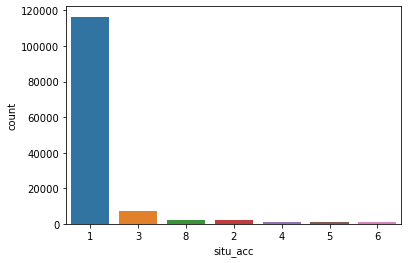

In [222]:
binning('situ_acc')

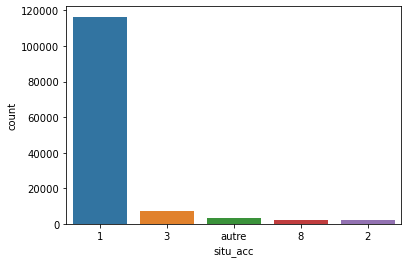

In [223]:
victml.situ_acc.replace(['4','5','6'], 'autre', inplace=True)
countplot('situ_acc')

BINNING FINE.


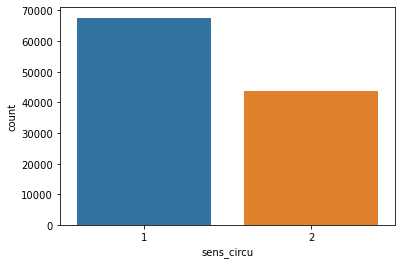

In [224]:
binning('sens_circu')

COLUMN TO BE BINNED.
7     84052
33     9144
10     8667
1      5198
2      4228
30     3587
32     2800
31     2101
34     1586
37     1322
3      1174
15     1022
14      894
17      844
50      715
43      558
99      532
38      511
13      478
21      263
80      261
20      248
36      199
40      196
60      141
39       58
16       43
42       40
35       26
41       13
Name: type_veh, dtype: int64


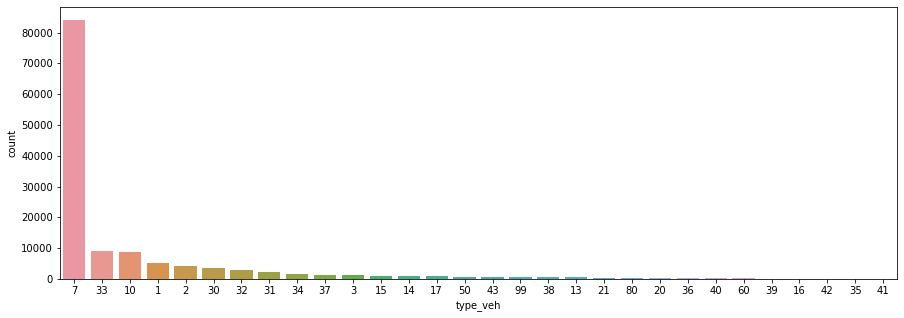

In [225]:
binning('type_veh')
plt.figure(figsize=(15, 5))
countplot('type_veh')

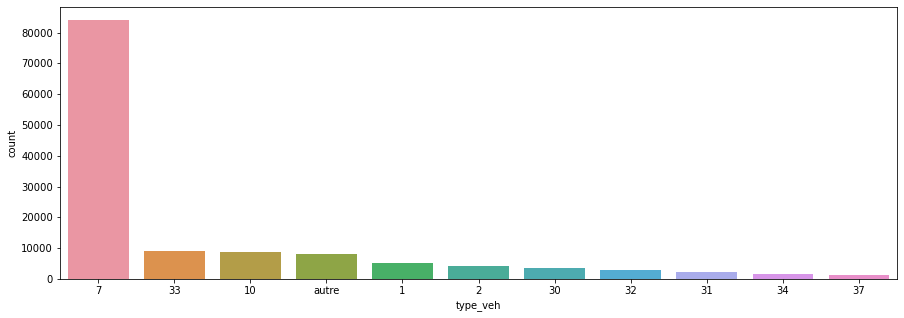

In [226]:
victml.type_veh.replace(['3','15','14','17','50','43','99','38','13','21','80','20','36','40','60','39','16','42','35','41'],'autre', inplace=True)
plt.figure(figsize=(15, 5))
countplot('type_veh')

COLUMN TO BE BINNED.
1     3028
13    2704
2     2213
3     2093
4     2004
6     1699
8     1628
14    1019
12     987
15     801
9      623
16     583
7      433
11     285
17     228
5      227
10     185
Name: obst_fixe, dtype: int64


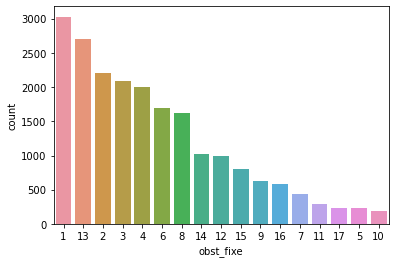

In [227]:
binning('obst_fixe')

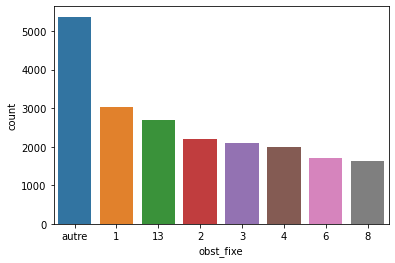

In [228]:
victml.obst_fixe.replace(['14','12','15','9','16','7','11','17','5','10'],'autre', inplace=True)
countplot('obst_fixe')

COLUMN TO BE BINNED.
2    84013
1    20170
9      985
6      797
4       96
5       73
Name: obst_mobile, dtype: int64


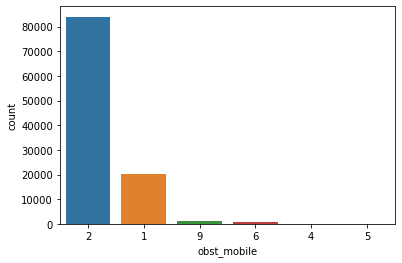

In [229]:
binning('obst_mobile')

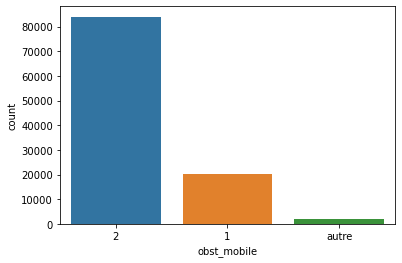

In [230]:
victml.obst_mobile.replace(['4','5','6','9'],'autre', inplace=True)
countplot('obst_mobile')

BINNING FINE.


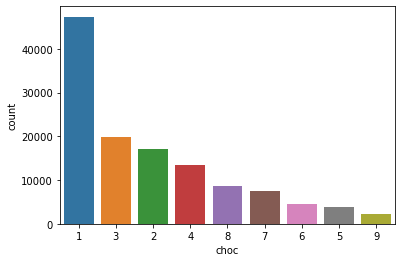

In [231]:
binning('choc')

COLUMN TO BE BINNED.
1     62054
2     14634
15    10366
13     5736
26     4770
17     4426
23     3610
9      3569
16     3415
19     3108
14     2862
21     2125
11     1370
5      1289
12     1278
3      1261
10      871
20      862
4       845
18      652
24      508
22      399
25      325
7       321
6       196
8        49
Name: manoeuvre_veh, dtype: int64


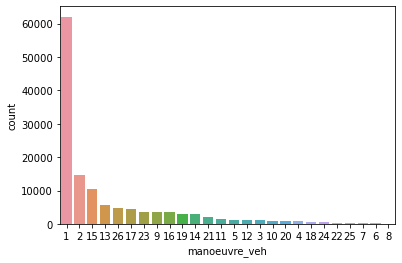

In [232]:
binning('manoeuvre_veh')

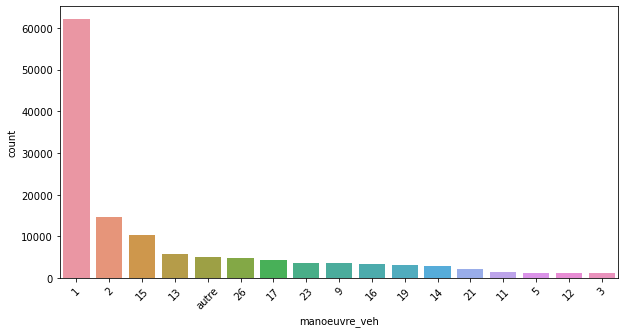

In [233]:
victml.manoeuvre_veh.replace(['10','20','4','18','24','22','25','6','7','8'],'autre', inplace=True)
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
countplot('manoeuvre_veh')

COLUMN TO BE BINNED.
A01    79110
B01    43848
C01     5396
D01     1184
Z01      760
E01      287
F01      108
Y01       48
G01       47
H01       22
T01       17
I01       16
M01       11
K01       10
J01        8
L01        7
W01        4
X01        4
Q01        4
N01        3
O01        3
U01        2
P01        1
V01        1
Name: num_veh, dtype: int64


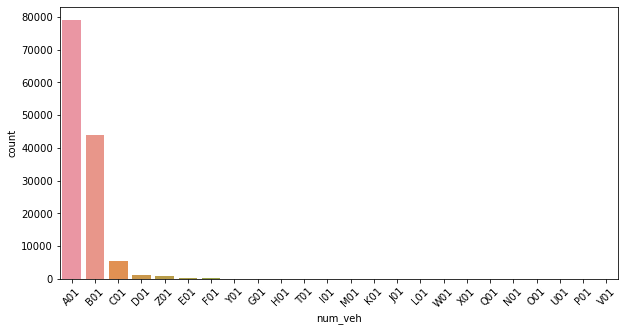

In [234]:
binning('num_veh')
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
countplot('num_veh')

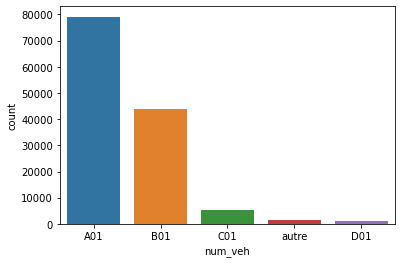

In [235]:
victml.num_veh.replace(['E01','F01','G01','H01','I01','J01','K01','L01','M01','N01','O01','P01','Q01','T01','U01','V01','W01','X01','Y01','Z01'],'autre', inplace=True)
countplot('num_veh')

COLUMN TO BE BINNED.
1     95846
2     15280
10    10645
3      2502
4      2271
9      1505
7      1330
5       750
8       603
6       169
Name: place_veh, dtype: int64


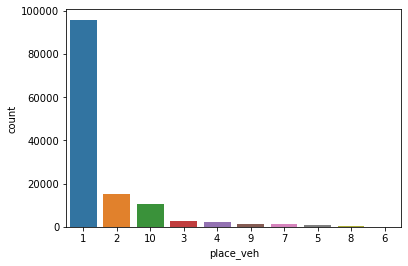

In [236]:
binning('place_veh')

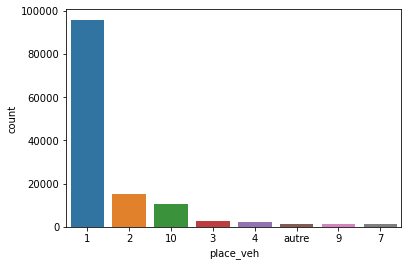

In [237]:
victml.place_veh.replace(['5','6','8'],'autre', inplace=True)
countplot('place_veh')

BINNING FINE.


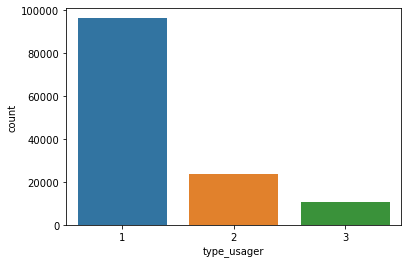

In [238]:
binning('type_usager')

BINNING FINE.


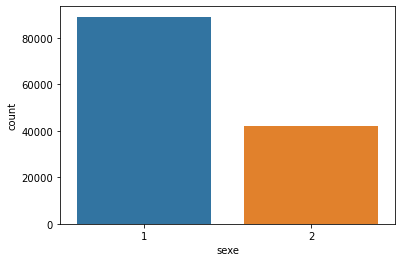

In [239]:
binning('sexe')

COLUMN TO BE BINNED.
2000    3766
1999    3646
1998    3562
1997    3491
1996    3432
        ... 
1922      15
1921       5
1920       5
1919       3
1911       1
Name: an_nais, Length: 103, dtype: int64


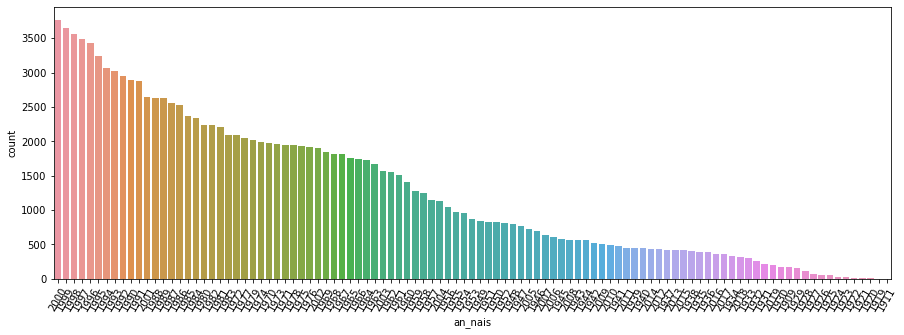

In [240]:
binning('an_nais')
plt.figure(figsize=(15, 5))
plt.xticks(rotation=60)
countplot('an_nais')

In [241]:
victml.an_nais.quantile(.5)

1983.0

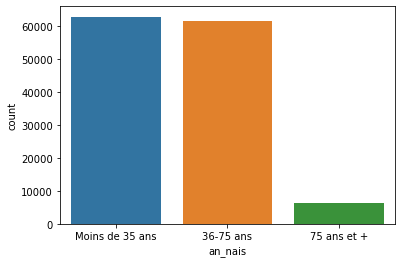

In [242]:
#on regroupe en 3 classes d'âge.
victml['an_nais'] = pd.cut(victml['an_nais'], [1909,1944,1984,2019], right=True, labels=['75 ans et +','36-75 ans','Moins de 35 ans'])
countplot('an_nais')

In [243]:
victml.an_nais.dtypes

CategoricalDtype(categories=['75 ans et +', '36-75 ans', 'Moins de 35 ans'], ordered=True)

COLUMN TO BE BINNED.
3    3330
2    2426
4    1608
1    1546
5     751
9     516
6     287
8     166
7      15
Name: loc_pieton, dtype: int64


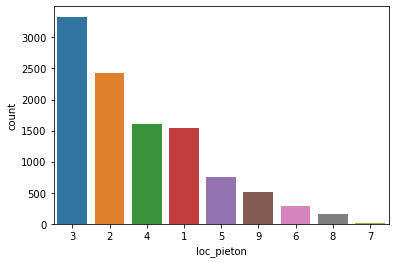

In [244]:
binning('loc_pieton')

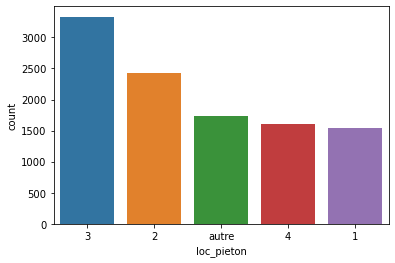

In [245]:
victml.loc_pieton.replace(['5','9','6','8','7'],'autre', inplace=True)
countplot('loc_pieton')

COLUMN TO BE BINNED.
3    7934
9     673
1     645
5     443
B     369
2     297
4     159
A      97
6      28
Name: manoeuvre_pieton, dtype: int64
Une valeur prédomine de façon écrasante. On supprime la colonne.


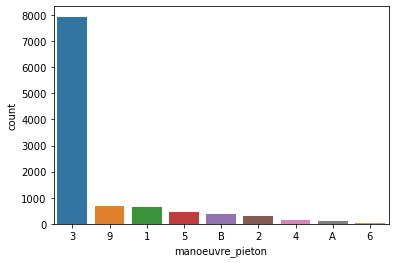

In [246]:
victml.loc[(victml.manoeuvre_pieton=='7')|(victml.manoeuvre_pieton=='8'),'manoeuvre_pieton']='9'
binning('manoeuvre_pieton')
print("Une valeur prédomine de façon écrasante. On supprime la colonne.")
victml.drop('manoeuvre_pieton', axis=1, inplace=True)

COLUMN TO BE BINNED.
1    8080
2    2142
3     423
Name: pieton_seul, dtype: int64


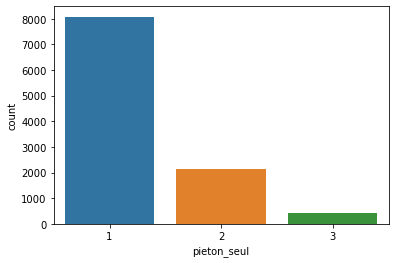

In [247]:
binning('pieton_seul')

BINNING FINE.


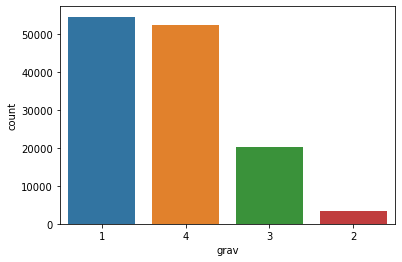

In [248]:
binning('grav')

**Taille du dataset**

Notre jeu de données a désormais la forme suivante.

In [249]:
victml.shape

(130901, 30)

In [250]:
victml.dtypes

mois                    int64
lum                    object
dep                    object
agglo                  object
intersection           object
meteo                  object
collision              object
type_route             object
type_circu             object
nb_voies                int64
declivite              object
rectitude              object
surface                object
infrastructure         object
situ_acc               object
vitesse_autorisee       int64
sens_circu             object
type_veh               object
obst_fixe              object
obst_mobile            object
choc                   object
manoeuvre_veh          object
num_veh                object
place_veh              object
type_usager            object
sexe                   object
an_nais              category
loc_pieton             object
pieton_seul            object
grav                   object
dtype: object

In [251]:
victmlminmax = pd.DataFrame({'victml_valeur_min':victml[victml!='IRLVT'].min(), 'victml_valeur_max':victml[victml!='IRLVT'].max()})
victmlminmax

,victml_valeur_min,victml_valeur_max
mois,1,12
lum,1,5
dep,Ile de france,Sud Ouest
agglo,1,2
meteo,1,autre
type_route,1,autre
type_circu,1,4
nb_voies,0,12
declivite,1,4
rectitude,1,4


In [ ]:
stop

**Corrélations**

Recherchons les fortes corrélations entre colonnes (qui sont à éviter). 
Nous les recherchons sur les colonnes de type numérique (matrice de Pearson) et sur les colonnes de type catégoriel (matrice de Cramer).


*Matrice de Pearson*

Nous fixons à 90% le seuil à partir duquel nous considérons que la corrélation entre 2 colonnes numériques est telle qu'il convient de supprimer l'une des 2 colonnes.
En l'occurrence, ce seuil n'est atteint pour aucune paire de colonnes, aussi nous n'identifions pas de colonnes redondantes.

<AxesSubplot:>

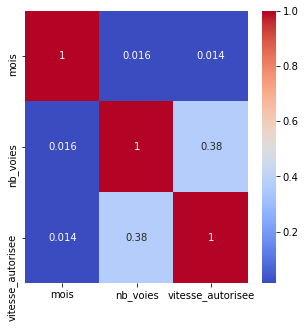

In [252]:
plt.figure(figsize=(5, 5))
sns.heatmap(victml.corr(), cmap="coolwarm", annot=True)

*Matrice de Cramer*

Nous fixons à 60% le seuil à partir duquel nous considérons que la corrélation entre 2 colonnes catégorielles est telle qu'il convient de supprimer l'une des 2 colonnes.

In [253]:
_DEFAULT_REPLACE_VALUE = 0.0

def _inf_nan_str(x):
    if np.isnan(x):
        return 'NaN'
    elif abs(x) == np.inf:
        return 'inf'
    else:
        return ''
def replace_nan_with_value(x, y, value):
    x = np.array([v if v == v and v is not None else value for v in x])  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y
def cramers_v(x,
              y,
              bias_correction=False,
              nan_strategy='replace',
              nan_replace_value=_DEFAULT_REPLACE_VALUE):
    if nan_strategy == 'replace':
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == 'drop':
        x, y = remove_incomplete_samples(x, y)
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    if bias_correction:
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        if min((kcorr - 1), (rcorr - 1)) == 0:
            warnings.warn(
                "Unable to calculate Cramer's V using bias correction. Consider using bias_correction=False",
                RuntimeWarning)
            return np.nan
        else:
            return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    else:
        return np.sqrt(phi2 / min(k - 1, r - 1))

<AxesSubplot:>

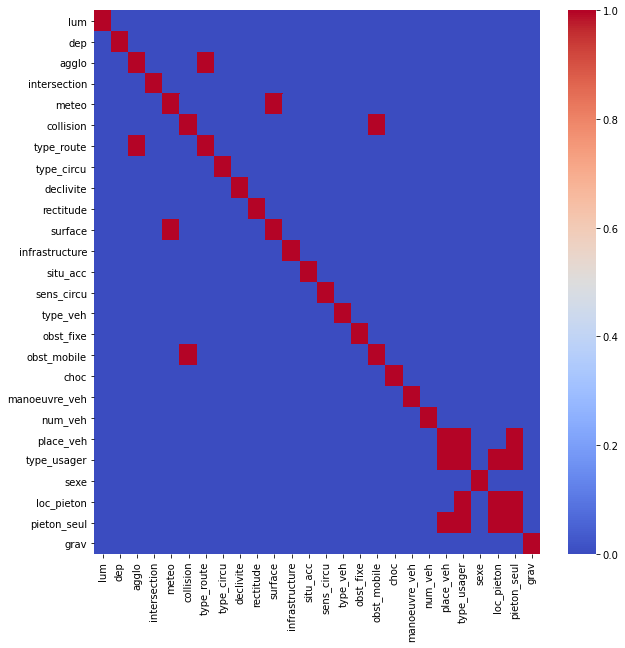

In [254]:
chi2 = pd.DataFrame(np.zeros((len(victml_cat.columns), len(victml_cat.columns))), columns=victml_cat.columns, index=victml_cat.columns)
for i, c1 in enumerate(victml_cat.columns):
    for j, c2 in enumerate(victml_cat.columns):
        chi2.iloc[i, j] = cramers_v(victml_cat[c1], victml_cat[c2], bias_correction=False)

plt.figure(figsize=(10, 10))
sns.heatmap(chi2>0.5, annot=False, cmap='coolwarm')

<AxesSubplot:xlabel='type_route', ylabel='agglo'>

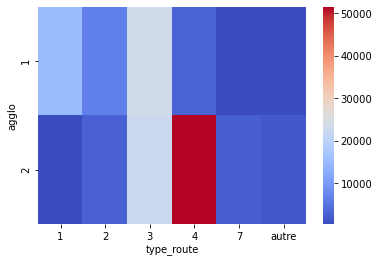

In [255]:
# Une corrélation forte est constatée entre les variables 'type de route' et 'en agglo/hors agglo', sur plusieurs valeurs.
# De plus les résultats nous paraissent surprenants (pourquoi pas une plus grande corrélation entre 'autoroute' et 'hors agglo' ?)

ct_counts = victml.groupby(['type_route', 'agglo']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'agglo', columns = 'type_route', values = 'count')
sns.heatmap(ct_counts, cmap="coolwarm")

In [256]:
#victml.drop('type_route', axis=1, inplace=True)

<AxesSubplot:xlabel='surface', ylabel='meteo'>

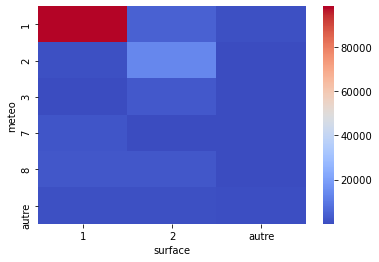

In [257]:
# Une corrélation très forte est constatée entre les variables 
# Mais c'est surtout une corrélation entre deux valeurs plutôt qu'entre plusieurs valeurs. Nous conservons les variables.

ct_counts = victml.groupby(['surface', 'meteo']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'meteo', columns = 'surface', values = 'count')
sns.heatmap(ct_counts, cmap="coolwarm")

<AxesSubplot:xlabel='type_usager', ylabel='loc_pieton'>

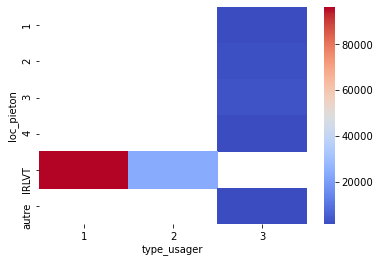

In [258]:
# Une corrélation forte est constatée entre les variables 
# 'Localisation du piéton'  et 'Type d'usager' 
# Mais c'est surtout une corrélation entre deux valeurs plutôt qu'entre plusieurs valeurs. Nous conservons les variables. 

ct_counts = victml.groupby(['type_usager', 'loc_pieton']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'loc_pieton', columns = 'type_usager', values = 'count')
sns.heatmap(ct_counts, cmap="coolwarm")

<AxesSubplot:xlabel='collision', ylabel='obst_mobile'>

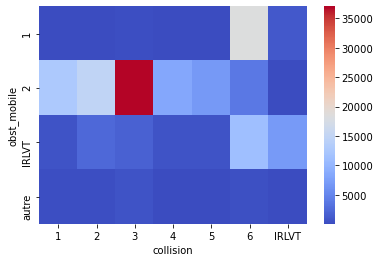

In [259]:
# Une corrélation forte est constatée entre les variables 
# 'obstacle mobile heurté' (1: piéton, 2:véhicule)  et 'collision' (3: frontale entre véhicules, 6: autre type de collision qu'avec un véhicule) 
# Les informations ne sont pas similaires, on conserve.

ct_counts = victml.groupby(['obst_mobile', 'collision']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'obst_mobile', columns = 'collision', values = 'count')
sns.heatmap(ct_counts, cmap="coolwarm")

In [260]:
#victml.drop('collision', axis=1, inplace=True)

<AxesSubplot:xlabel='type_usager', ylabel='pieton_seul'>

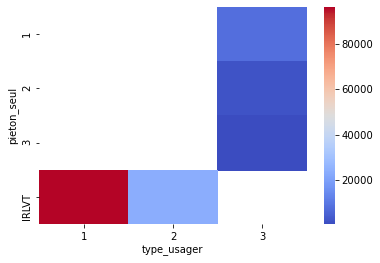

In [261]:
# Une corrélation forte est constatée entre les variables  
# Localisation du piéton  // Type d'usager 
# Mais c'est surtout une corrélation entre deux valeurs plutôt qu'entre plusieurs valeurs. Nous conservons les variables.

ct_counts = victml.groupby(['type_usager', 'pieton_seul']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'pieton_seul', columns = 'type_usager', values = 'count')
sns.heatmap(ct_counts, cmap="coolwarm")

**Fléau de la dimension**

Notre jeu de données a désormais la forme suivante.

In [262]:
victml.shape

(130901, 30)

Conscient du fléau de la dimension, on vérifie que le nombre de lignes est très largement proportionnel au nombre de features.

In [263]:
victml.shape[0]/victml.shape[1]

4363.366666666667

In [264]:
victml.to_csv('../Final-Project/data/victime_clean_forTableau.csv', index=False)

**Génération d'un PANDAS PROFILE REPORT** 

In [265]:
ppr = ProfileReport(victml.sample(130901), title="Pandas Profiling Report")
ppr.to_file("ppr_new.html")

**One-hot-encoding**

On procède à l'encodage des variables catégorielles en variables factices en vue du traitement de machine learning.

In [271]:
# On exclut la variable-cible et les variables numériques
features = victml.columns.drop(['vitesse_autorisee','nb_voies','grav'])
features

Index(['mois', 'lum', 'dep', 'agglo', 'intersection', 'meteo', 'collision',
       'type_route', 'type_circu', 'declivite', 'rectitude', 'surface',
       'infrastructure', 'situ_acc', 'sens_circu', 'type_veh', 'obst_fixe',
       'obst_mobile', 'choc', 'manoeuvre_veh', 'num_veh', 'place_veh',
       'type_usager', 'sexe', 'an_nais', 'loc_pieton', 'pieton_seul'],
      dtype='object')

In [272]:
victml_dummies = pd.get_dummies(victml, columns = features, drop_first=True)

In [273]:
victml_dummies.shape

(130901, 141)

In [274]:
list(victml_dummies.columns)

['nb_voies',
 'vitesse_autorisee',
 'grav',
 'mois_2',
 'mois_3',
 'mois_4',
 'mois_5',
 'mois_6',
 'mois_7',
 'mois_8',
 'mois_9',
 'mois_10',
 'mois_11',
 'mois_12',
 'lum_2',
 'lum_3',
 'lum_4',
 'lum_5',
 'dep_Nord Est',
 'dep_Nord-Ouest',
 'dep_Sud Est',
 'dep_Sud Ouest',
 'agglo_2',
 'intersection_3',
 'intersection_4',
 'intersection_6',
 'intersection_7',
 'intersection_9',
 'intersection_IRLVT',
 'intersection_autre',
 'meteo_2',
 'meteo_3',
 'meteo_7',
 'meteo_8',
 'meteo_autre',
 'collision_2',
 'collision_3',
 'collision_4',
 'collision_5',
 'collision_6',
 'collision_IRLVT',
 'type_route_2',
 'type_route_3',
 'type_route_4',
 'type_route_7',
 'type_route_autre',
 'type_circu_2',
 'type_circu_3',
 'type_circu_4',
 'declivite_2',
 'declivite_3',
 'declivite_4',
 'rectitude_2',
 'rectitude_3',
 'rectitude_4',
 'surface_2',
 'surface_autre',
 'infrastructure_2',
 'infrastructure_3',
 'infrastructure_4',
 'infrastructure_5',
 'infrastructure_6',
 'infrastructure_9',
 'infrastru

Sauvegardons le jeu de données préparé pour le machine learning.

In [275]:
victml_dummies.to_csv('../Final-Project/data/victime_clean_dummies.csv', index=False)

In [276]:
print('Done!')

Done!
